# 23_04_25_03_erythroid_lineage_下游分析5_从源点到终点的最短路径

> 参考：/mnt/h/F_bak/Python进阶/scRNA/Other/MyRNAVelocity/23_03_07_模型搭建完成后的实验部分/23_03_20_3_原肠胚抽样数据整体串联.ipynb

In [22]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import anndata as ad
import scanpy as sc
import scvelo as scv
import velovgi

In [23]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

## 1. 读取结果

1. adata

In [24]:
# adata_dir = "tmp/erythroid_lineage/adata"
adata_dir = "tmp/erythroid_lineage2/adata"
adata = velovgi.tl.read_adata(adata_dir)
batch_key = "stage"
cluster_key = "celltype"
adata

load tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

2. model

In [25]:
# velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage/model", adata=adata, use_gpu=True)
velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage2/model", adata=adata, use_gpu=True)

INFO     File tmp/erythroid_lineage2/model/model.pt already downloaded                                             


## 2. 隐层表示

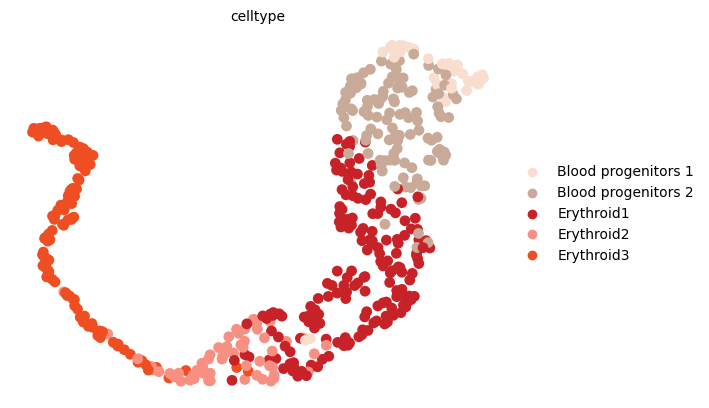

In [26]:
latent_representation = velovgi_model.get_latent_representation(adata)
latent_adata = ad.AnnData(latent_representation)
latent_adata.obs.index = adata.obs.index
latent_adata.obs[batch_key] = adata.obs[batch_key]
latent_adata.obs[cluster_key] = adata.obs[cluster_key]
latent_adata.uns["%s_colors"%cluster_key] = adata.uns["%s_colors"%cluster_key]
# 直接作为主成分进行降维、可视化
latent_adata.obsm["X_pca"] = latent_adata.X.copy()
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
scv.pl.umap(latent_adata, color=cluster_key, legend_loc="right")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_latent_representation_umap', embedded velocity vectors (adata.obsm)


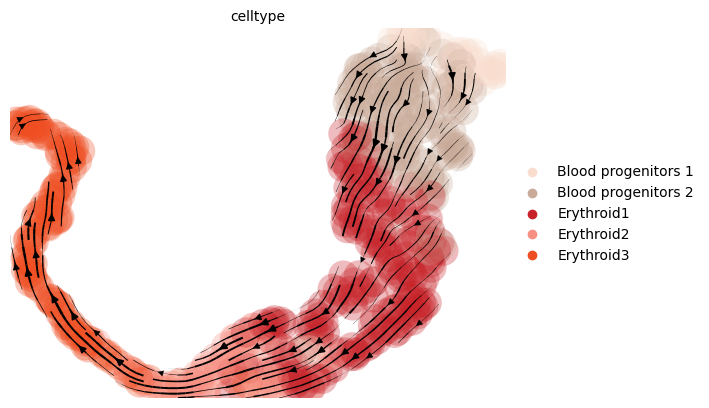

In [27]:
# 重新计算转移概率后可视化速率图
latent_umap_key = "X_latent_representation_umap"
adata.obsm[latent_umap_key] = latent_adata.obsm["X_umap"]
scv.pl.velocity_embedding_stream(adata, color=cluster_key, basis=latent_umap_key, legend_loc="right")

## 3. 最短路径(这里搜索有点问题,比较难看)

In [28]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

1. 原始降维图上的起点、终点搜索

In [29]:
umap = adata.obsm["X_umap"]

# 找坐标范围
x_min, y_min = umap.min(axis=0)
x_max, y_max = umap.max(axis=0)
print("X(%.2f~%.2f), Y(%.2f~%.2f)"%(x_min, x_max, y_min, y_max))

X(-0.48~10.71), Y(4.81~15.52)


In [30]:
# 找起点、终点
bool_array = (umap[:, 0] < 0.48) # 找左边的细胞作为起点
source = np.arange(bool_array.shape[0])[bool_array][0]
bool_array = (umap[:, 1] < 5)  # 找下边的细胞作为终点
target = np.arange(bool_array.shape[0])[bool_array][0]

umap_points = [source, target]

2. 新降维图上的最短路径起点、终点搜索

In [31]:
latent_umap = adata.obsm["X_latent_representation_umap"]

# 找坐标范围
x_min, y_min = latent_umap.min(axis=0)
x_max, y_max = latent_umap.max(axis=0)
print("X(%.2f~%.2f), Y(%.2f~%.2f)"%(x_min, x_max, y_min, y_max))

X(-1.29~17.68), Y(-2.55~14.70)


In [33]:
# 找起点、终点
bool_array = (latent_umap[:, 1] > 12) # 找上边的细胞作为起点
source = np.arange(bool_array.shape[0])[bool_array][0]
bool_array = (latent_umap[:, 0] < -1.2)  # 找左边的细胞作为终点
target = np.arange(bool_array.shape[0])[bool_array][0]

latent_umap_points = [source, target]

3. 绘图

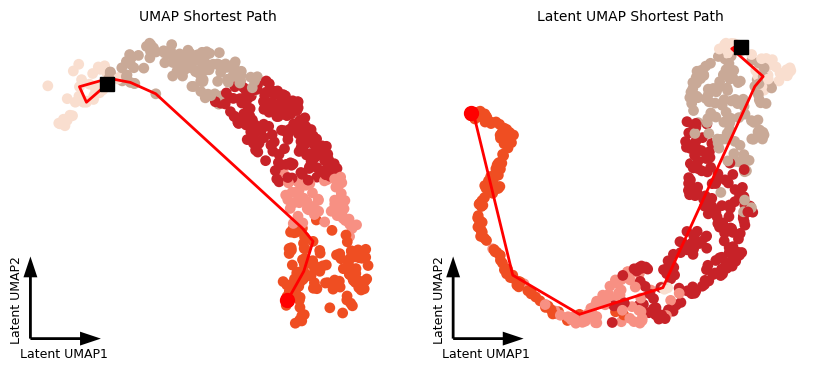

In [34]:
fig, ax=plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

G = nx.from_scipy_sparse_array(adata.obsp["connectivities"])
shortest_path = nx.shortest_path(G, source=source, target=target)
shortest_path_umap = umap[shortest_path]
source_umap = umap[source]
target_umap = umap[target]
ax[0].plot(shortest_path_umap[:, 0], shortest_path_umap[:, 1], color='r', linewidth=2) # 轨迹的终点画圆圈
ax[0].plot(target_umap[0], target_umap[1], color='r', linewidth=2, marker='o', markersize=10) # 轨迹的终点画圆圈
ax[0].plot(source_umap[0], source_umap[1], color='k', linewidth=2, marker='s', markersize=10)# 轨迹的起点画方框
scv.pl.scatter(adata, ax=ax[0], color=cluster_key, basis="X_umap",
               xlabel='Latent UMAP1', ylabel='Latent UMAP2', title="UMAP Shortest Path",
               frameon="artist", legend_loc="none", show=False)

ax[0].xaxis.label.set_size(9)
ax[0].yaxis.label.set_size(9)

G = nx.from_scipy_sparse_array(adata.obsp["connectivities"])
shortest_path = nx.shortest_path(G, source=source, target=target)
shortest_path_umap = latent_umap[shortest_path]
source_umap = latent_umap[latent_umap_points[0]]
target_umap = latent_umap[latent_umap_points[1]]
ax[1].plot(shortest_path_umap[:, 0], shortest_path_umap[:, 1], color='r', linewidth=2) # 轨迹的终点画圆圈
ax[1].plot(target_umap[0], target_umap[1], color='r', linewidth=2, marker='o', markersize=10) # 轨迹的终点画圆圈
ax[1].plot(source_umap[0], source_umap[1], color='k', linewidth=2, marker='s', markersize=10)# 轨迹的起点画方框
scv.pl.scatter(adata, ax=ax[1], color=cluster_key, basis="X_latent_representation_umap",
               xlabel='Latent UMAP1', ylabel='Latent UMAP2', title="Latent UMAP Shortest Path",
               frameon="artist", legend_loc="none", show=False)

ax[1].xaxis.label.set_size(9)
ax[1].yaxis.label.set_size(9)


## 3. Dynamo最短路径搜索优化